In [1]:
import feature_extraction as fe

import numpy as np

import os
import random
import pickle
import warnings
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 3
random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
def data_batcher(data, batch_size):
    random.shuffle(data)
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

In [3]:
dataset = 'GTZAN'
new_feats = False


dataset_filename = f'../datasets/{dataset}.gui'
pickle_filename = f'./feats_spects-pickles/{dataset_filename.split("/")[-1][:-4]}_feats.pkl'

        
if new_feats or not os.path.isfile(pickle_filename):
    feats, labels = fe.extract_numfeats(dataset_filename)
    with open(pickle_filename, 'wb') as f:
        pickle.dump([feats, labels], f)
else:
    with open(pickle_filename, 'rb') as f:
        feats, labels = pickle.load(f)
    print(f'{feats.shape[0]} features extracted')

1000 features extracted


In [4]:
scaler = StandardScaler()
scaled_feats = scaler.fit_transform(feats)

x_trainval, x_test, y_trainval, y_test = train_test_split(scaled_feats, labels, test_size=1/10) # NO TOCAR!
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=1/9)        # NO TOCAR!

train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]

print(len(train_data), "training samples")
print(len(val_data), "validation samples")
print(len(test_data), "test samples")

800 training samples
100 validation samples
100 test samples


In [5]:
# Fully connected neural network with one hidden layer
class DNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout):
        super(DNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], hidden_size[3])
        self.fc5 = nn.Linear(hidden_size[3], num_classes)
        
        self.bn2 = nn.BatchNorm1d(hidden_size[1])
        self.bn3 = nn.BatchNorm1d(hidden_size[2])
        self.bn4 = nn.BatchNorm1d(hidden_size[3])
        
        self.drop_layer = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x # we can return here the softmax, but then we should use the nll_loss instead of the cross_entropy

In [6]:
def train(log_interval, model, device, data_batches, optimizer, epoch):
    losses = []
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.train()
    
    for i, batch in enumerate(data_batches):
        x, y = list(zip(*batch))
        
        # Move tensors to the configured device
        data = torch.from_numpy(np.array(x)).float().to(device)
        target = torch.from_numpy(np.array(y)).to(device)
        
        # clear all the gradients of the optimized tensors
        optimizer.zero_grad()
    
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (i+1) % log_interval == 0:
            print(f'Train Epoch: {epoch+1} [{str((i+1)*len(data)).zfill((len(str(len_glob_data))))}/{len_glob_data} ({str(int(100. * (i+1)*len(data) / len_glob_data)).zfill(2)}%)]\tLoss: {round(loss.item(),6)}')
    return np.array(losses).mean()

In [7]:
def validate(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = []
    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            validation_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss = np.array(validation_loss).mean()
    accuracy = 100. * correct / len_glob_data

    print(f'\nValidation set: Average loss: {round(validation_loss, 4)}, Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy, validation_loss

In [8]:
def test(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len_glob_data

    print(f'Test set: Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy

In [9]:
def plt_curves(train_losses, valid_losses, accuracies):
    fig = plt.figure()
    fig.subplots_adjust(right=2.5)

    ax1 = fig.add_subplot(121)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.plot(train_losses, 'b-', label='Train')
    ax1.plot(valid_losses, 'r-', label='Validation')
    ax1.legend(loc='upper right')

    ax1 = fig.add_subplot(122)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.plot(accuracies, 'b-')

    plt.show()

In [10]:
# Hyperparameters

input_size = 25
num_classes = 10

train_batch_size = 5 # NO TOCAR!
valid_batch_size = 100

hidden_size_list = [[256, 128, 64, 32], [512, 256, 128, 64], [128, 64, 32, 16]]
num_epochs = 200
learning_rate_list = [0.001, 0.0001, 0.00005]
dropout_list = [0.1, 0.25, 0.5]


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [256, 128, 64, 32]	Learning Rate = 0.001

Validation set: Average loss: 1.9611, Accuracy: 38/100 (38%)


Validation set: Average loss: 1.8455, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.6752, Accuracy: 49/100 (49%)


Validation set: Average loss: 1.5717, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.5361, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.4784, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.4351, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.3301, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3251, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.3281, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.379, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.3713, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.3348, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.3641, Accuracy: 57/100 (57%)


Validation set: Ave


Validation set: Average loss: 2.334, Accuracy: 58/100 (58%)


Validation set: Average loss: 2.4353, Accuracy: 58/100 (58%)


Validation set: Average loss: 2.3707, Accuracy: 53/100 (53%)


Validation set: Average loss: 2.3701, Accuracy: 55/100 (55%)


Validation set: Average loss: 2.0376, Accuracy: 57/100 (57%)


Validation set: Average loss: 2.3628, Accuracy: 52/100 (52%)


Validation set: Average loss: 2.2197, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.9548, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.9753, Accuracy: 55/100 (55%)


Validation set: Average loss: 2.0203, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.9646, Accuracy: 60/100 (60%)


Validation set: Average loss: 2.2353, Accuracy: 55/100 (55%)


Validation set: Average loss: 2.2299, Accuracy: 55/100 (55%)


Validation set: Average loss: 2.3763, Accuracy: 55/100 (55%)


Validation set: Average loss: 2.3651, Accuracy: 55/100 (55%)


Validation set: Average loss: 2.3985, Accuracy: 54/100 

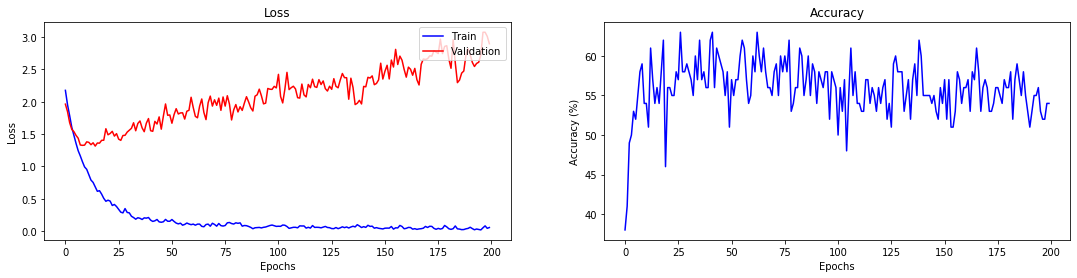


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [256, 128, 64, 32]	Learning Rate = 0.001

Validation set: Average loss: 2.0626, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.9026, Accuracy: 38/100 (38%)


Validation set: Average loss: 1.7767, Accuracy: 38/100 (38%)


Validation set: Average loss: 1.6698, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.6652, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.522, Accuracy: 49/100 (49%)


Validation set: Average loss: 1.4936, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4652, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4495, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.4266, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.4361, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.4087, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.3605, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.3508, Accuracy: 55/100 (55%)


Validation set: Av


Validation set: Average loss: 1.5767, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4846, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.5672, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.5411, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.4477, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.5032, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.5214, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.5042, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.513, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.4765, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.5192, Accuracy: 64/100 (64%)


Validation set: Average loss: 1.4346, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.4539, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.5062, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.4665, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.4437, Accuracy: 63/100 

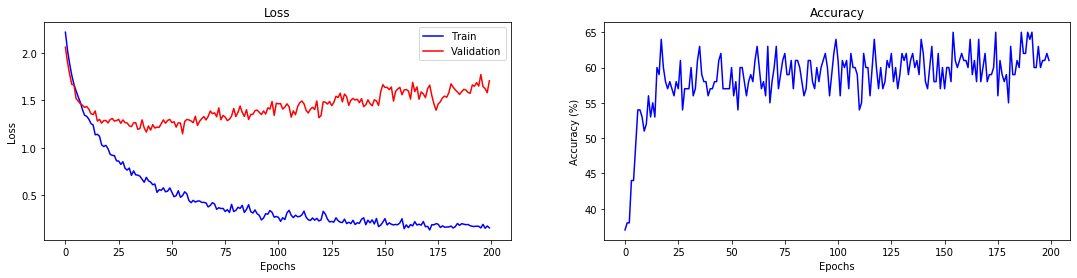


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [256, 128, 64, 32]	Learning Rate = 0.001

Validation set: Average loss: 2.2058, Accuracy: 35/100 (35%)


Validation set: Average loss: 2.0864, Accuracy: 35/100 (35%)


Validation set: Average loss: 1.9381, Accuracy: 38/100 (38%)


Validation set: Average loss: 1.8559, Accuracy: 34/100 (34%)


Validation set: Average loss: 1.7754, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.7385, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.7168, Accuracy: 36/100 (36%)


Validation set: Average loss: 1.6982, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.6797, Accuracy: 38/100 (38%)


Validation set: Average loss: 1.6268, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.6631, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.6171, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.5696, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.5506, Accuracy: 47/100 (47%)


Validation set: Av


Validation set: Average loss: 1.2689, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.2831, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.276, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.2924, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.3125, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.2936, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3276, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.2791, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.2774, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.3056, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.3033, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.2842, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.2743, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.3261, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.3329, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.3246, Accuracy: 59/100 

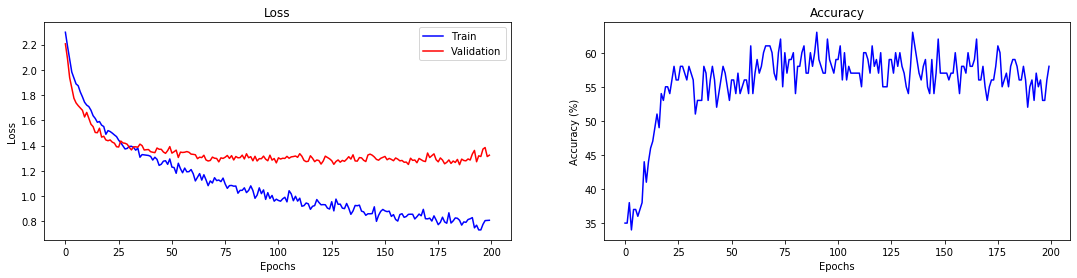


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [256, 128, 64, 32]	Learning Rate = 0.0001

Validation set: Average loss: 2.2231, Accuracy: 26/100 (26%)


Validation set: Average loss: 2.1626, Accuracy: 29/100 (29%)


Validation set: Average loss: 2.1234, Accuracy: 33/100 (33%)


Validation set: Average loss: 2.093, Accuracy: 33/100 (33%)


Validation set: Average loss: 2.0614, Accuracy: 33/100 (33%)


Validation set: Average loss: 2.0252, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.9982, Accuracy: 39/100 (39%)


Validation set: Average loss: 1.961, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.9461, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.9202, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.9082, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.8747, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.8383, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.8123, Accuracy: 45/100 (45%)


Validation set: Ave


Validation set: Average loss: 1.359, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.3239, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.3506, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.3596, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.3674, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.3418, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.3177, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3699, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.3301, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.3962, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.395, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.3725, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.4225, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4093, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4434, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.4333, Accuracy: 57/100 (

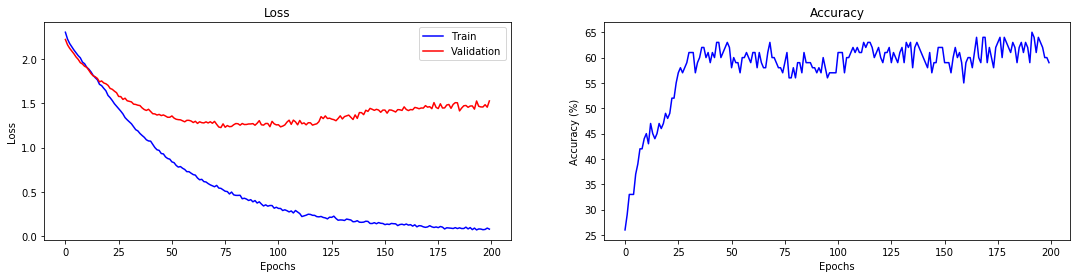


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [256, 128, 64, 32]	Learning Rate = 0.0001

Validation set: Average loss: 2.2713, Accuracy: 18/100 (18%)


Validation set: Average loss: 2.2294, Accuracy: 20/100 (20%)


Validation set: Average loss: 2.2062, Accuracy: 25/100 (25%)


Validation set: Average loss: 2.1819, Accuracy: 25/100 (25%)


Validation set: Average loss: 2.1627, Accuracy: 33/100 (33%)


Validation set: Average loss: 2.1372, Accuracy: 35/100 (35%)


Validation set: Average loss: 2.116, Accuracy: 34/100 (34%)


Validation set: Average loss: 2.0852, Accuracy: 36/100 (36%)


Validation set: Average loss: 2.0706, Accuracy: 39/100 (39%)


Validation set: Average loss: 2.0671, Accuracy: 40/100 (40%)


Validation set: Average loss: 2.0366, Accuracy: 38/100 (38%)


Validation set: Average loss: 2.0254, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.9856, Accuracy: 40/100 (40%)


Validation set: Average loss: 1.9946, Accuracy: 41/100 (41%)


Validation set: A


Validation set: Average loss: 1.2732, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.2762, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.2721, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.258, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.2546, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.2405, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.2539, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.2599, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.2405, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.2528, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.2608, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.2508, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.2578, Accuracy: 64/100 (64%)


Validation set: Average loss: 1.2503, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.2511, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.227, Accuracy: 64/100 (

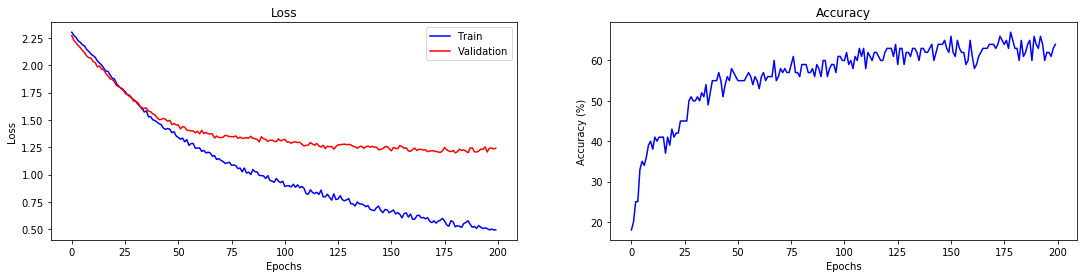


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [256, 128, 64, 32]	Learning Rate = 0.0001

Validation set: Average loss: 2.2808, Accuracy: 14/100 (14%)


Validation set: Average loss: 2.2696, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2539, Accuracy: 16/100 (16%)


Validation set: Average loss: 2.2338, Accuracy: 22/100 (22%)


Validation set: Average loss: 2.229, Accuracy: 23/100 (23%)


Validation set: Average loss: 2.2249, Accuracy: 25/100 (25%)


Validation set: Average loss: 2.204, Accuracy: 27/100 (27%)


Validation set: Average loss: 2.1848, Accuracy: 28/100 (28%)


Validation set: Average loss: 2.1549, Accuracy: 28/100 (28%)


Validation set: Average loss: 2.1518, Accuracy: 39/100 (39%)


Validation set: Average loss: 2.114, Accuracy: 36/100 (36%)


Validation set: Average loss: 2.1296, Accuracy: 37/100 (37%)


Validation set: Average loss: 2.1033, Accuracy: 40/100 (40%)


Validation set: Average loss: 2.1191, Accuracy: 34/100 (34%)


Validation set: Aver


Validation set: Average loss: 1.372, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.3938, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.4071, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.3841, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.3804, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.3577, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.4009, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.4395, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.383, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.368, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3789, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4054, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.4196, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3826, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.3687, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3678, Accuracy: 59/100 (5

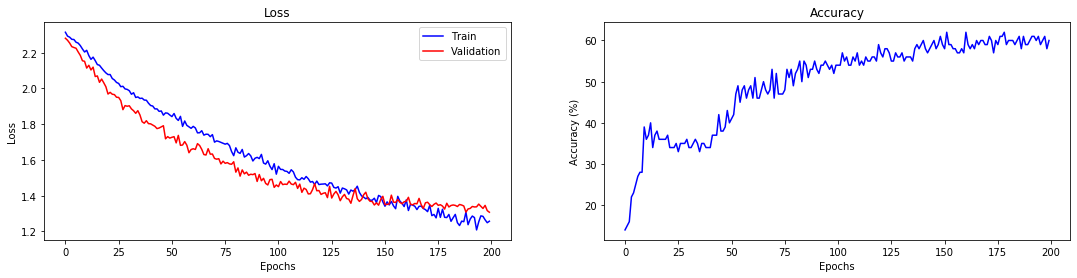


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [256, 128, 64, 32]	Learning Rate = 5e-05

Validation set: Average loss: 2.2946, Accuracy: 11/100 (11%)


Validation set: Average loss: 2.2568, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2294, Accuracy: 18/100 (18%)


Validation set: Average loss: 2.2057, Accuracy: 19/100 (19%)


Validation set: Average loss: 2.1765, Accuracy: 26/100 (26%)


Validation set: Average loss: 2.1557, Accuracy: 29/100 (29%)


Validation set: Average loss: 2.1353, Accuracy: 32/100 (32%)


Validation set: Average loss: 2.1142, Accuracy: 32/100 (32%)


Validation set: Average loss: 2.0969, Accuracy: 33/100 (33%)


Validation set: Average loss: 2.0852, Accuracy: 35/100 (35%)


Validation set: Average loss: 2.0646, Accuracy: 34/100 (34%)


Validation set: Average loss: 2.0415, Accuracy: 35/100 (35%)


Validation set: Average loss: 2.0347, Accuracy: 36/100 (36%)


Validation set: Average loss: 2.0217, Accuracy: 38/100 (38%)


Validation set: Av


Validation set: Average loss: 1.2895, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.3, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.2904, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.2866, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.2909, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3037, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.2993, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.2816, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.2988, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.2787, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.2929, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.287, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.2684, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.2833, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.2819, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.2904, Accuracy: 62/100 (62

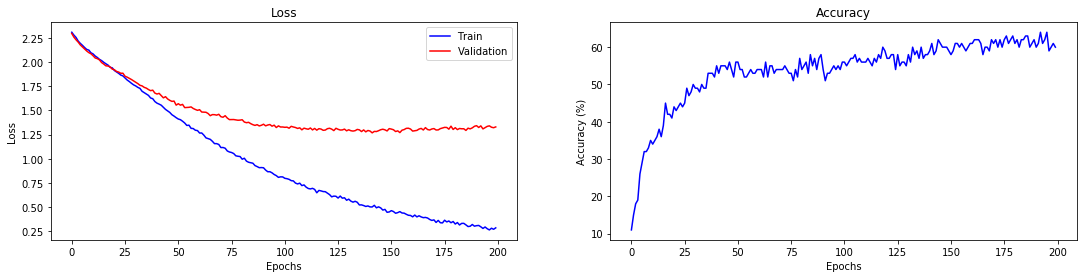


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [256, 128, 64, 32]	Learning Rate = 5e-05

Validation set: Average loss: 2.2656, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2406, Accuracy: 25/100 (25%)


Validation set: Average loss: 2.2316, Accuracy: 23/100 (23%)


Validation set: Average loss: 2.221, Accuracy: 22/100 (22%)


Validation set: Average loss: 2.1992, Accuracy: 25/100 (25%)


Validation set: Average loss: 2.1864, Accuracy: 23/100 (23%)


Validation set: Average loss: 2.1671, Accuracy: 26/100 (26%)


Validation set: Average loss: 2.1619, Accuracy: 29/100 (29%)


Validation set: Average loss: 2.1585, Accuracy: 29/100 (29%)


Validation set: Average loss: 2.1559, Accuracy: 31/100 (31%)


Validation set: Average loss: 2.1272, Accuracy: 27/100 (27%)


Validation set: Average loss: 2.1211, Accuracy: 32/100 (32%)


Validation set: Average loss: 2.0998, Accuracy: 36/100 (36%)


Validation set: Average loss: 2.0711, Accuracy: 36/100 (36%)


Validation set: Av


Validation set: Average loss: 1.4612, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.427, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.4365, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4192, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4305, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4168, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.4116, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4271, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4234, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4208, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.4122, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.4497, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4249, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.4209, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3941, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.4249, Accuracy: 59/100 

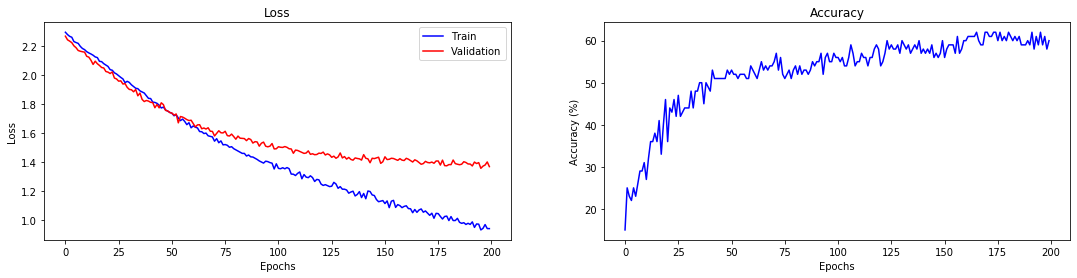


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [256, 128, 64, 32]	Learning Rate = 5e-05

Validation set: Average loss: 2.3138, Accuracy: 3/100 (3%)


Validation set: Average loss: 2.315, Accuracy: 8/100 (8%)


Validation set: Average loss: 2.3107, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.308, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.3046, Accuracy: 13/100 (13%)


Validation set: Average loss: 2.2941, Accuracy: 13/100 (13%)


Validation set: Average loss: 2.2822, Accuracy: 16/100 (16%)


Validation set: Average loss: 2.278, Accuracy: 21/100 (21%)


Validation set: Average loss: 2.2753, Accuracy: 17/100 (17%)


Validation set: Average loss: 2.2733, Accuracy: 20/100 (20%)


Validation set: Average loss: 2.2693, Accuracy: 19/100 (19%)


Validation set: Average loss: 2.2576, Accuracy: 25/100 (25%)


Validation set: Average loss: 2.2612, Accuracy: 18/100 (18%)


Validation set: Average loss: 2.2461, Accuracy: 22/100 (22%)


Validation set: Average l


Validation set: Average loss: 1.5693, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.6118, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.5974, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.6024, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.5652, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.5912, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.6181, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.5904, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.6085, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.5681, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.5936, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.5594, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.5766, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.5986, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.5493, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.5869, Accuracy: 47/100

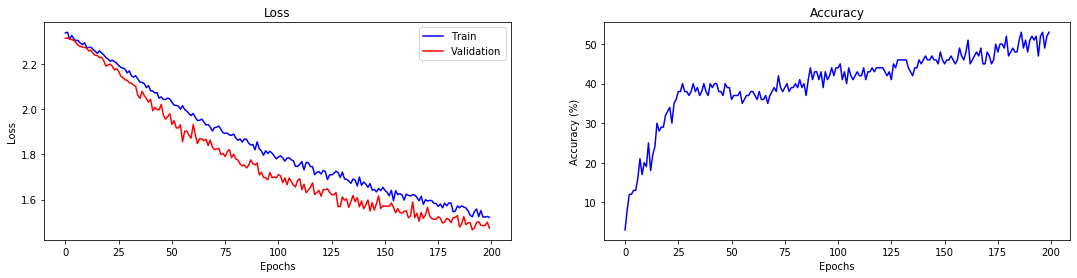


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [512, 256, 128, 64]	Learning Rate = 0.001

Validation set: Average loss: 1.7635, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.5951, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.486, Accuracy: 48/100 (48%)


Validation set: Average loss: 1.435, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.4419, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.3782, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.3679, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.3135, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.376, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.3437, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.3499, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.2997, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4602, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.4898, Accuracy: 56/100 (56%)


Validation set: Aver


Validation set: Average loss: 2.4639, Accuracy: 60/100 (60%)


Validation set: Average loss: 2.3979, Accuracy: 60/100 (60%)


Validation set: Average loss: 2.5696, Accuracy: 54/100 (54%)


Validation set: Average loss: 2.4189, Accuracy: 57/100 (57%)


Validation set: Average loss: 2.4164, Accuracy: 54/100 (54%)


Validation set: Average loss: 2.3107, Accuracy: 56/100 (56%)


Validation set: Average loss: 2.29, Accuracy: 60/100 (60%)


Validation set: Average loss: 2.4073, Accuracy: 55/100 (55%)


Validation set: Average loss: 2.3425, Accuracy: 61/100 (61%)


Validation set: Average loss: 2.403, Accuracy: 62/100 (62%)


Validation set: Average loss: 2.3603, Accuracy: 63/100 (63%)


Validation set: Average loss: 2.3345, Accuracy: 62/100 (62%)


Validation set: Average loss: 2.3447, Accuracy: 61/100 (61%)


Validation set: Average loss: 2.3742, Accuracy: 62/100 (62%)


Validation set: Average loss: 2.4331, Accuracy: 64/100 (64%)


Validation set: Average loss: 2.4518, Accuracy: 61/100 (6

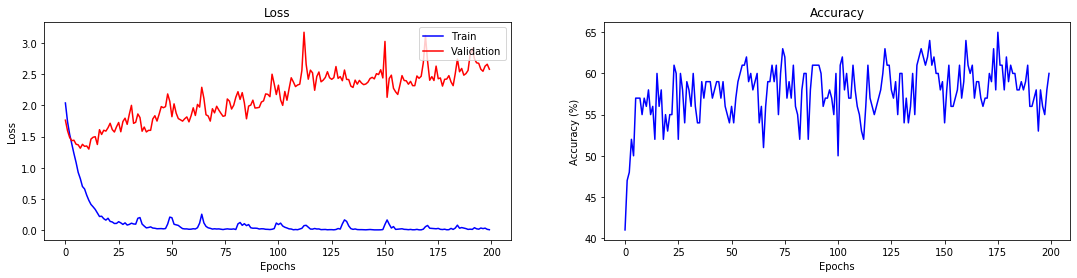


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [512, 256, 128, 64]	Learning Rate = 0.001

Validation set: Average loss: 1.853, Accuracy: 35/100 (35%)


Validation set: Average loss: 1.7056, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.6227, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.6008, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.4643, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4729, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.3832, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4226, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.3329, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3329, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3165, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.3575, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.2755, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.3462, Accuracy: 56/100 (56%)


Validation set: A


Validation set: Average loss: 2.1775, Accuracy: 55/100 (55%)


Validation set: Average loss: 2.1108, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.9702, Accuracy: 57/100 (57%)


Validation set: Average loss: 2.1349, Accuracy: 59/100 (59%)


Validation set: Average loss: 2.1154, Accuracy: 59/100 (59%)


Validation set: Average loss: 2.0244, Accuracy: 58/100 (58%)


Validation set: Average loss: 2.0412, Accuracy: 59/100 (59%)


Validation set: Average loss: 2.1225, Accuracy: 60/100 (60%)


Validation set: Average loss: 2.0779, Accuracy: 58/100 (58%)


Validation set: Average loss: 2.0818, Accuracy: 59/100 (59%)


Validation set: Average loss: 2.1132, Accuracy: 56/100 (56%)


Validation set: Average loss: 2.3943, Accuracy: 51/100 (51%)


Validation set: Average loss: 2.4336, Accuracy: 53/100 (53%)


Validation set: Average loss: 2.3465, Accuracy: 56/100 (56%)


Validation set: Average loss: 2.3446, Accuracy: 54/100 (54%)


Validation set: Average loss: 2.2875, Accuracy: 56/100

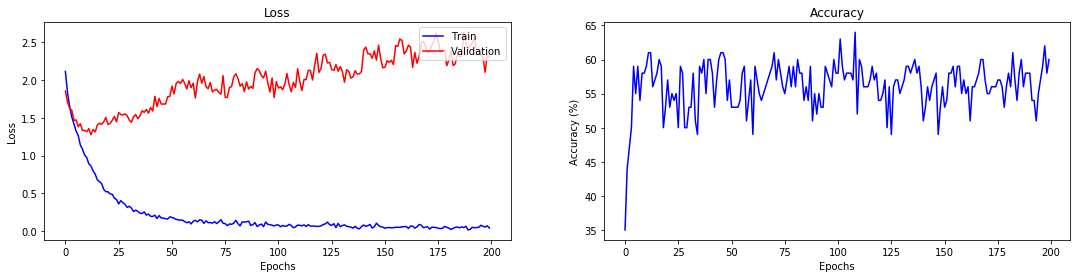


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [512, 256, 128, 64]	Learning Rate = 0.001

Validation set: Average loss: 1.9947, Accuracy: 28/100 (28%)


Validation set: Average loss: 1.7892, Accuracy: 34/100 (34%)


Validation set: Average loss: 1.6638, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.6559, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.5736, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.5353, Accuracy: 49/100 (49%)


Validation set: Average loss: 1.5011, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.5253, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.5007, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.4763, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.4514, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.4574, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.3894, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.3847, Accuracy: 55/100 (55%)


Validation set: A


Validation set: Average loss: 1.4109, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.4642, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.4069, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.4743, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.3779, Accuracy: 65/100 (65%)


Validation set: Average loss: 1.3654, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.386, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4112, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.4284, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4949, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.4614, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3911, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.4115, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.4112, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4388, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.3892, Accuracy: 60/100 

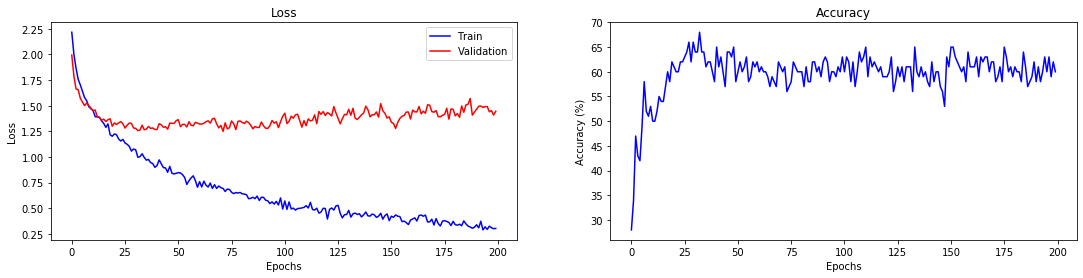


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [512, 256, 128, 64]	Learning Rate = 0.0001

Validation set: Average loss: 2.1458, Accuracy: 34/100 (34%)


Validation set: Average loss: 2.0522, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.9851, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.9384, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.8796, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.844, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.8228, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.8279, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.7734, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.7692, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.7354, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.6879, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.6455, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.6371, Accuracy: 53/100 (53%)


Validation set: A


Validation set: Average loss: 1.6093, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.5646, Accuracy: 67/100 (67%)


Validation set: Average loss: 1.4863, Accuracy: 65/100 (65%)


Validation set: Average loss: 1.5565, Accuracy: 65/100 (65%)


Validation set: Average loss: 1.6692, Accuracy: 64/100 (64%)


Validation set: Average loss: 1.592, Accuracy: 67/100 (67%)


Validation set: Average loss: 1.5805, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.528, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.5415, Accuracy: 65/100 (65%)


Validation set: Average loss: 1.4652, Accuracy: 65/100 (65%)


Validation set: Average loss: 1.5879, Accuracy: 64/100 (64%)


Validation set: Average loss: 1.5402, Accuracy: 65/100 (65%)


Validation set: Average loss: 1.4958, Accuracy: 68/100 (68%)


Validation set: Average loss: 1.5043, Accuracy: 65/100 (65%)


Validation set: Average loss: 1.491, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.5463, Accuracy: 67/100 (6

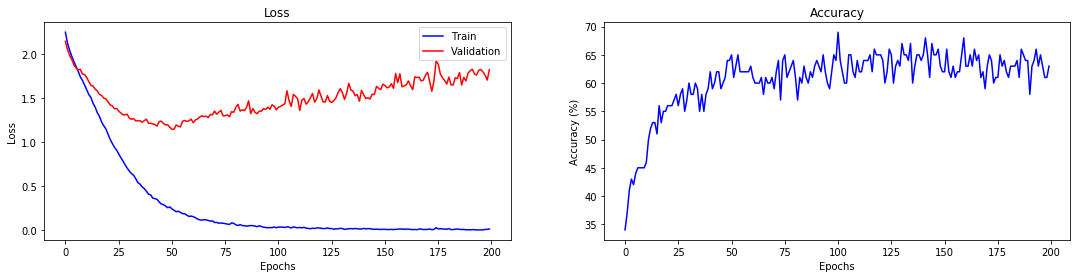


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [512, 256, 128, 64]	Learning Rate = 0.0001

Validation set: Average loss: 2.2106, Accuracy: 29/100 (29%)


Validation set: Average loss: 2.1236, Accuracy: 32/100 (32%)


Validation set: Average loss: 2.0662, Accuracy: 34/100 (34%)


Validation set: Average loss: 1.9939, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.9374, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.9033, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.8479, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.8247, Accuracy: 48/100 (48%)


Validation set: Average loss: 1.8105, Accuracy: 48/100 (48%)


Validation set: Average loss: 1.7688, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.7332, Accuracy: 49/100 (49%)


Validation set: Average loss: 1.7067, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.6851, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.6696, Accuracy: 49/100 (49%)


Validation set:


Validation set: Average loss: 1.2173, Accuracy: 67/100 (67%)


Validation set: Average loss: 1.2118, Accuracy: 64/100 (64%)


Validation set: Average loss: 1.2608, Accuracy: 69/100 (69%)


Validation set: Average loss: 1.2314, Accuracy: 68/100 (68%)


Validation set: Average loss: 1.3083, Accuracy: 65/100 (65%)


Validation set: Average loss: 1.2719, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.3221, Accuracy: 64/100 (64%)


Validation set: Average loss: 1.3127, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.3124, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.3639, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.3427, Accuracy: 66/100 (66%)


Validation set: Average loss: 1.3002, Accuracy: 65/100 (65%)


Validation set: Average loss: 1.3122, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.326, Accuracy: 66/100 (66%)


Validation set: Average loss: 1.2942, Accuracy: 67/100 (67%)


Validation set: Average loss: 1.3048, Accuracy: 64/100 

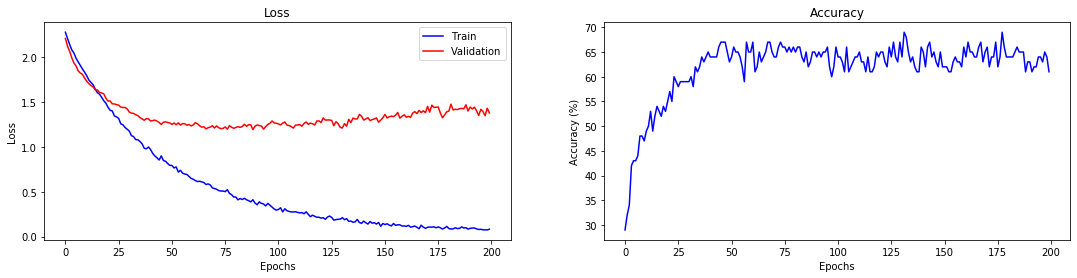


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [512, 256, 128, 64]	Learning Rate = 0.0001

Validation set: Average loss: 2.3139, Accuracy: 10/100 (10%)


Validation set: Average loss: 2.2823, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.2642, Accuracy: 14/100 (14%)


Validation set: Average loss: 2.2295, Accuracy: 29/100 (29%)


Validation set: Average loss: 2.1902, Accuracy: 31/100 (31%)


Validation set: Average loss: 2.1545, Accuracy: 32/100 (32%)


Validation set: Average loss: 2.1273, Accuracy: 31/100 (31%)


Validation set: Average loss: 2.0892, Accuracy: 31/100 (31%)


Validation set: Average loss: 2.0759, Accuracy: 32/100 (32%)


Validation set: Average loss: 2.0174, Accuracy: 31/100 (31%)


Validation set: Average loss: 2.0028, Accuracy: 32/100 (32%)


Validation set: Average loss: 1.9575, Accuracy: 35/100 (35%)


Validation set: Average loss: 1.9475, Accuracy: 33/100 (33%)


Validation set: Average loss: 1.9034, Accuracy: 34/100 (34%)


Validation set: 


Validation set: Average loss: 1.2512, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.2771, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.2693, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.2642, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.2684, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.266, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.2659, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.2768, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.2657, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.262, Accuracy: 65/100 (65%)


Validation set: Average loss: 1.255, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.2609, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.2644, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.2661, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.2631, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.2607, Accuracy: 60/100 (6

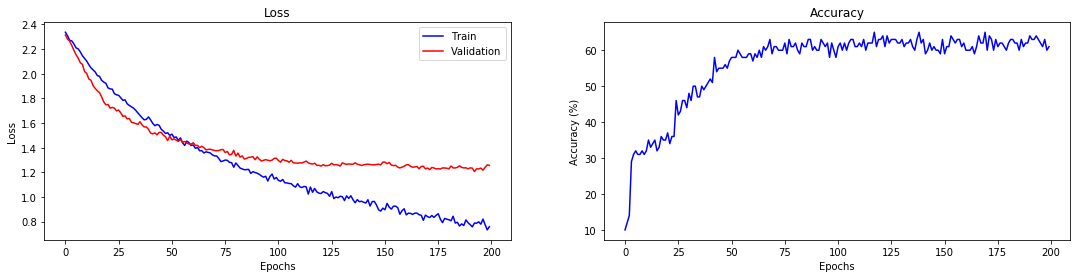


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [512, 256, 128, 64]	Learning Rate = 5e-05

Validation set: Average loss: 2.2326, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.1728, Accuracy: 34/100 (34%)


Validation set: Average loss: 2.1262, Accuracy: 36/100 (36%)


Validation set: Average loss: 2.0778, Accuracy: 38/100 (38%)


Validation set: Average loss: 2.0336, Accuracy: 41/100 (41%)


Validation set: Average loss: 2.003, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.9758, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.9458, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.9274, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.8978, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.8743, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.8551, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.8357, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.8228, Accuracy: 47/100 (47%)


Validation set: Av


Validation set: Average loss: 1.438, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.4649, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4807, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4768, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.4756, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.4667, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.5023, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4869, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.5121, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.4742, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.5086, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4996, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.5054, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.5149, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.498, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.4768, Accuracy: 59/100 (

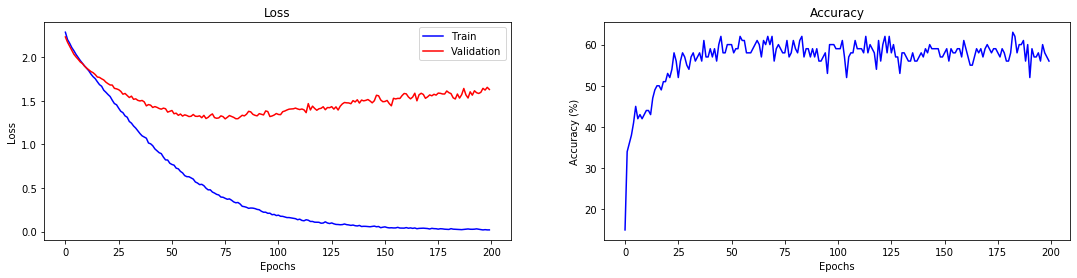


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [512, 256, 128, 64]	Learning Rate = 5e-05

Validation set: Average loss: 2.2513, Accuracy: 16/100 (16%)


Validation set: Average loss: 2.2229, Accuracy: 18/100 (18%)


Validation set: Average loss: 2.1895, Accuracy: 31/100 (31%)


Validation set: Average loss: 2.1663, Accuracy: 40/100 (40%)


Validation set: Average loss: 2.1423, Accuracy: 37/100 (37%)


Validation set: Average loss: 2.1143, Accuracy: 39/100 (39%)


Validation set: Average loss: 2.1046, Accuracy: 40/100 (40%)


Validation set: Average loss: 2.0696, Accuracy: 40/100 (40%)


Validation set: Average loss: 2.0563, Accuracy: 42/100 (42%)


Validation set: Average loss: 2.0354, Accuracy: 38/100 (38%)


Validation set: Average loss: 2.0087, Accuracy: 39/100 (39%)


Validation set: Average loss: 2.0003, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.9652, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.9612, Accuracy: 46/100 (46%)


Validation set: 


Validation set: Average loss: 1.2369, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.2331, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.2171, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.2473, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.248, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.2545, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.2434, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.2256, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.2388, Accuracy: 65/100 (65%)


Validation set: Average loss: 1.2333, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.2445, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.2319, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.2569, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.2661, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.2397, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.244, Accuracy: 63/100 (

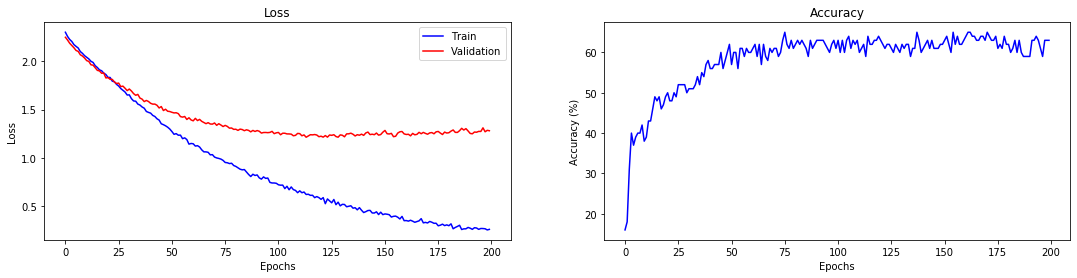


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [512, 256, 128, 64]	Learning Rate = 5e-05

Validation set: Average loss: 2.2938, Accuracy: 10/100 (10%)


Validation set: Average loss: 2.2797, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.2644, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2525, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.2391, Accuracy: 20/100 (20%)


Validation set: Average loss: 2.2252, Accuracy: 19/100 (19%)


Validation set: Average loss: 2.208, Accuracy: 24/100 (24%)


Validation set: Average loss: 2.1967, Accuracy: 23/100 (23%)


Validation set: Average loss: 2.1804, Accuracy: 26/100 (26%)


Validation set: Average loss: 2.1601, Accuracy: 31/100 (31%)


Validation set: Average loss: 2.1458, Accuracy: 38/100 (38%)


Validation set: Average loss: 2.1301, Accuracy: 34/100 (34%)


Validation set: Average loss: 2.1068, Accuracy: 35/100 (35%)


Validation set: Average loss: 2.1047, Accuracy: 35/100 (35%)


Validation set: Av


Validation set: Average loss: 1.3961, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.3938, Accuracy: 64/100 (64%)


Validation set: Average loss: 1.4002, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.3985, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.3876, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.3671, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.3931, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.3889, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.3688, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.3511, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.3785, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3744, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.385, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.3643, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.372, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.3587, Accuracy: 62/100 (

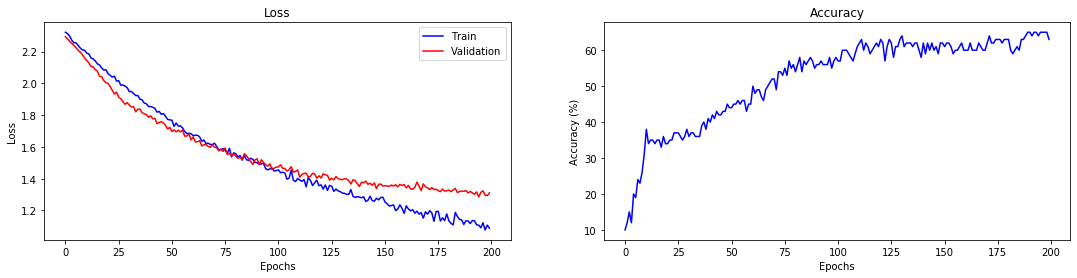


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [128, 64, 32, 16]	Learning Rate = 0.001

Validation set: Average loss: 2.0873, Accuracy: 28/100 (28%)


Validation set: Average loss: 1.9089, Accuracy: 40/100 (40%)


Validation set: Average loss: 1.826, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.7224, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.6687, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.5424, Accuracy: 49/100 (49%)


Validation set: Average loss: 1.5422, Accuracy: 49/100 (49%)


Validation set: Average loss: 1.4942, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.4586, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.461, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4289, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.4161, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.3958, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.3521, Accuracy: 55/100 (55%)


Validation set: Avera


Validation set: Average loss: 1.5273, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.6573, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.6777, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.8089, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.675, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.6535, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.6805, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.7978, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.8796, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.8524, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.812, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.7586, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.8029, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.7621, Accuracy: 63/100 (63%)


Validation set: Average loss: 1.6559, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.6653, Accuracy: 62/100 (

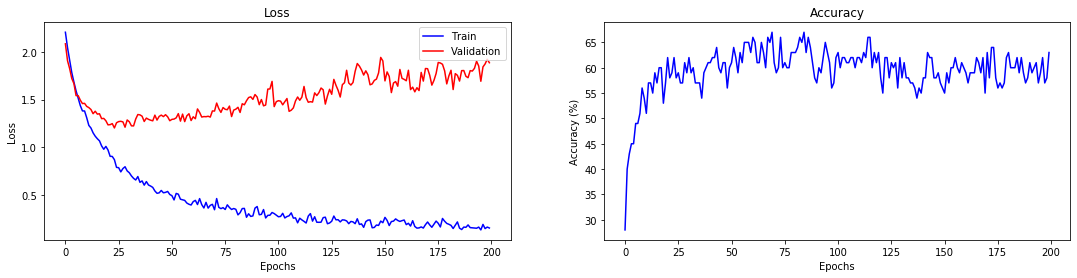


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [128, 64, 32, 16]	Learning Rate = 0.001

Validation set: Average loss: 2.0958, Accuracy: 30/100 (30%)


Validation set: Average loss: 1.9724, Accuracy: 38/100 (38%)


Validation set: Average loss: 1.8874, Accuracy: 38/100 (38%)


Validation set: Average loss: 1.8034, Accuracy: 39/100 (39%)


Validation set: Average loss: 1.7503, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.7247, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.6899, Accuracy: 48/100 (48%)


Validation set: Average loss: 1.6298, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.5787, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.5725, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.5608, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.5908, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.5242, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.6008, Accuracy: 45/100 (45%)


Validation set: Av


Validation set: Average loss: 1.489, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.4306, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4211, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.411, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.3833, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4485, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.4031, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3791, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4397, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.416, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.3861, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3976, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3958, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4276, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.383, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.363, Accuracy: 58/100 (58%

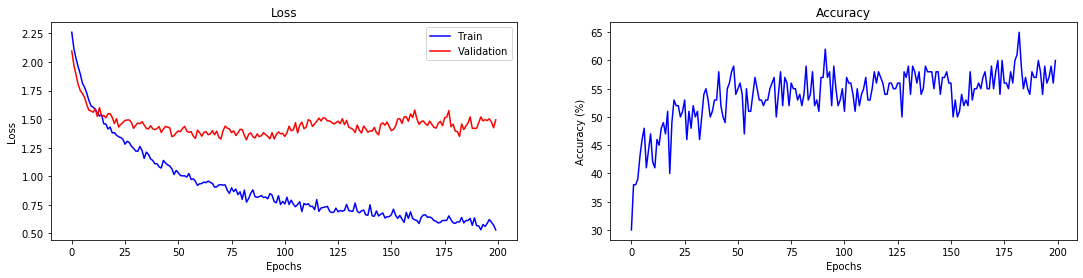


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [128, 64, 32, 16]	Learning Rate = 0.001

Validation set: Average loss: 2.2934, Accuracy: 11/100 (11%)


Validation set: Average loss: 2.2379, Accuracy: 20/100 (20%)


Validation set: Average loss: 2.1797, Accuracy: 24/100 (24%)


Validation set: Average loss: 2.0879, Accuracy: 28/100 (28%)


Validation set: Average loss: 2.0254, Accuracy: 29/100 (29%)


Validation set: Average loss: 1.9527, Accuracy: 36/100 (36%)


Validation set: Average loss: 1.9191, Accuracy: 36/100 (36%)


Validation set: Average loss: 1.8338, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.8899, Accuracy: 35/100 (35%)


Validation set: Average loss: 1.7851, Accuracy: 40/100 (40%)


Validation set: Average loss: 1.6984, Accuracy: 39/100 (39%)


Validation set: Average loss: 1.7136, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.7064, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.6786, Accuracy: 40/100 (40%)


Validation set: Ave


Validation set: Average loss: 1.4295, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4383, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4355, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.4296, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.4391, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3935, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4041, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4014, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3892, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.3726, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.3936, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4252, Accuracy: 61/100 (61%)


Validation set: Average loss: 1.4297, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.4092, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4018, Accuracy: 62/100 (62%)


Validation set: Average loss: 1.3892, Accuracy: 60/100

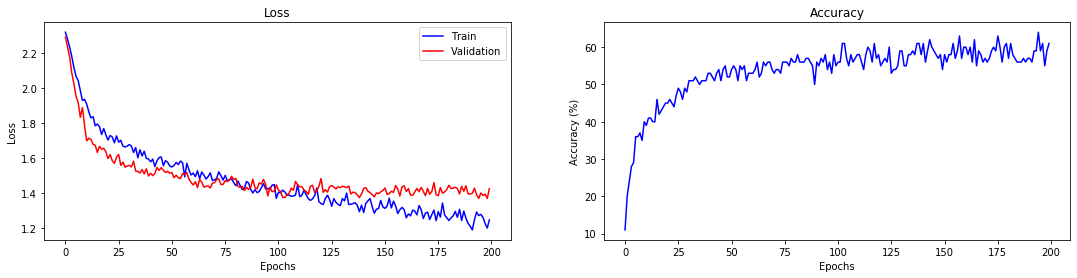


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [128, 64, 32, 16]	Learning Rate = 0.0001

Validation set: Average loss: 2.331, Accuracy: 7/100 (7%)


Validation set: Average loss: 2.3132, Accuracy: 8/100 (8%)


Validation set: Average loss: 2.2998, Accuracy: 11/100 (11%)


Validation set: Average loss: 2.281, Accuracy: 11/100 (11%)


Validation set: Average loss: 2.2654, Accuracy: 13/100 (13%)


Validation set: Average loss: 2.2455, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2392, Accuracy: 16/100 (16%)


Validation set: Average loss: 2.2277, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2079, Accuracy: 18/100 (18%)


Validation set: Average loss: 2.1986, Accuracy: 24/100 (24%)


Validation set: Average loss: 2.1913, Accuracy: 25/100 (25%)


Validation set: Average loss: 2.1631, Accuracy: 28/100 (28%)


Validation set: Average loss: 2.164, Accuracy: 30/100 (30%)


Validation set: Average loss: 2.1526, Accuracy: 32/100 (32%)


Validation set: Average l


Validation set: Average loss: 1.4048, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.413, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3919, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4238, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4017, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.4083, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3962, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4024, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.3943, Accuracy: 60/100 (60%)


Validation set: Average loss: 1.3767, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.3987, Accuracy: 58/100 (58%)


Validation set: Average loss: 1.4151, Accuracy: 59/100 (59%)


Validation set: Average loss: 1.4055, Accuracy: 57/100 (57%)


Validation set: Average loss: 1.3996, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.3897, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.4, Accuracy: 58/100 (58

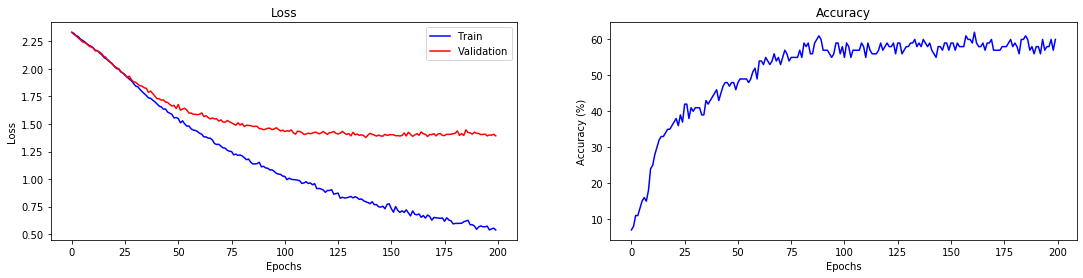


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [128, 64, 32, 16]	Learning Rate = 0.0001

Validation set: Average loss: 2.2808, Accuracy: 13/100 (13%)


Validation set: Average loss: 2.2464, Accuracy: 13/100 (13%)


Validation set: Average loss: 2.2265, Accuracy: 20/100 (20%)


Validation set: Average loss: 2.2072, Accuracy: 20/100 (20%)


Validation set: Average loss: 2.1894, Accuracy: 20/100 (20%)


Validation set: Average loss: 2.1885, Accuracy: 24/100 (24%)


Validation set: Average loss: 2.1763, Accuracy: 26/100 (26%)


Validation set: Average loss: 2.1548, Accuracy: 33/100 (33%)


Validation set: Average loss: 2.1343, Accuracy: 36/100 (36%)


Validation set: Average loss: 2.1162, Accuracy: 36/100 (36%)


Validation set: Average loss: 2.1146, Accuracy: 38/100 (38%)


Validation set: Average loss: 2.0956, Accuracy: 38/100 (38%)


Validation set: Average loss: 2.08, Accuracy: 39/100 (39%)


Validation set: Average loss: 2.0623, Accuracy: 40/100 (40%)


Validation set: Ave


Validation set: Average loss: 1.4639, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4536, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4285, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.4372, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.424, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.4459, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.4349, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4258, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4378, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.4383, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.4451, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.4327, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.4469, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.43, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.4231, Accuracy: 50/100 (50%)


Validation set: Average loss: 1.4217, Accuracy: 54/100 (5

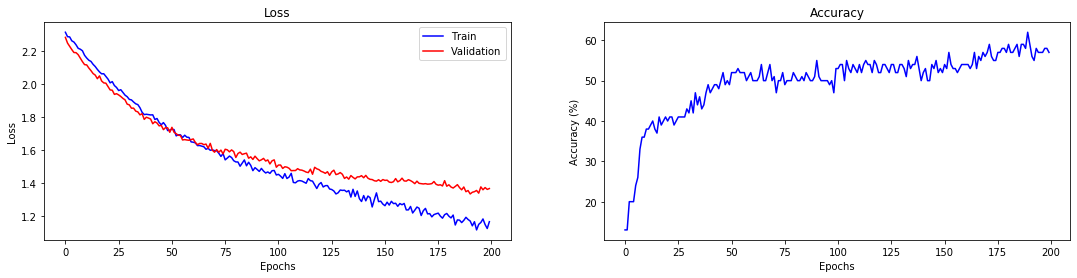


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [128, 64, 32, 16]	Learning Rate = 0.0001

Validation set: Average loss: 2.3261, Accuracy: 9/100 (9%)


Validation set: Average loss: 2.3183, Accuracy: 8/100 (8%)


Validation set: Average loss: 2.3128, Accuracy: 9/100 (9%)


Validation set: Average loss: 2.3007, Accuracy: 9/100 (9%)


Validation set: Average loss: 2.3015, Accuracy: 10/100 (10%)


Validation set: Average loss: 2.3024, Accuracy: 8/100 (8%)


Validation set: Average loss: 2.2943, Accuracy: 7/100 (7%)


Validation set: Average loss: 2.2827, Accuracy: 10/100 (10%)


Validation set: Average loss: 2.2706, Accuracy: 11/100 (11%)


Validation set: Average loss: 2.2738, Accuracy: 11/100 (11%)


Validation set: Average loss: 2.2574, Accuracy: 11/100 (11%)


Validation set: Average loss: 2.2582, Accuracy: 11/100 (11%)


Validation set: Average loss: 2.2573, Accuracy: 14/100 (14%)


Validation set: Average loss: 2.2383, Accuracy: 18/100 (18%)


Validation set: Average loss: 


Validation set: Average loss: 1.6847, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.6844, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.6942, Accuracy: 38/100 (38%)


Validation set: Average loss: 1.6854, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.6811, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.6826, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.7034, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.6069, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.6658, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.6119, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.6728, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.6683, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.6597, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.6442, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.6832, Accuracy: 42/100 (42%)


Validation set: Average loss: 1.6593, Accuracy: 41/100

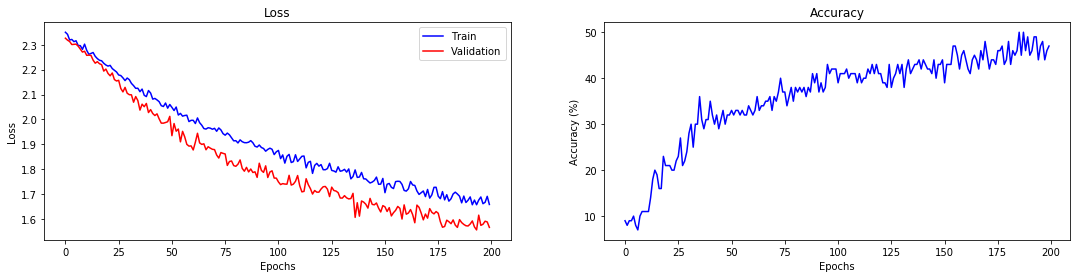


------ NEW EXPERIMENT ------
Dropout = 0.1	Hidden Size = [128, 64, 32, 16]	Learning Rate = 5e-05

Validation set: Average loss: 2.3407, Accuracy: 7/100 (7%)


Validation set: Average loss: 2.3156, Accuracy: 7/100 (7%)


Validation set: Average loss: 2.2983, Accuracy: 9/100 (9%)


Validation set: Average loss: 2.2943, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.2843, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.2724, Accuracy: 13/100 (13%)


Validation set: Average loss: 2.2637, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2508, Accuracy: 16/100 (16%)


Validation set: Average loss: 2.2453, Accuracy: 20/100 (20%)


Validation set: Average loss: 2.2386, Accuracy: 22/100 (22%)


Validation set: Average loss: 2.2338, Accuracy: 20/100 (20%)


Validation set: Average loss: 2.229, Accuracy: 20/100 (20%)


Validation set: Average loss: 2.223, Accuracy: 22/100 (22%)


Validation set: Average loss: 2.2129, Accuracy: 23/100 (23%)


Validation set: Average los


Validation set: Average loss: 1.4881, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.4784, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.4662, Accuracy: 53/100 (53%)


Validation set: Average loss: 1.4733, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4735, Accuracy: 51/100 (51%)


Validation set: Average loss: 1.4746, Accuracy: 52/100 (52%)


Validation set: Average loss: 1.4683, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4698, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4551, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4388, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.4333, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.4282, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.452, Accuracy: 55/100 (55%)


Validation set: Average loss: 1.4541, Accuracy: 56/100 (56%)


Validation set: Average loss: 1.4475, Accuracy: 54/100 (54%)


Validation set: Average loss: 1.442, Accuracy: 55/100 (

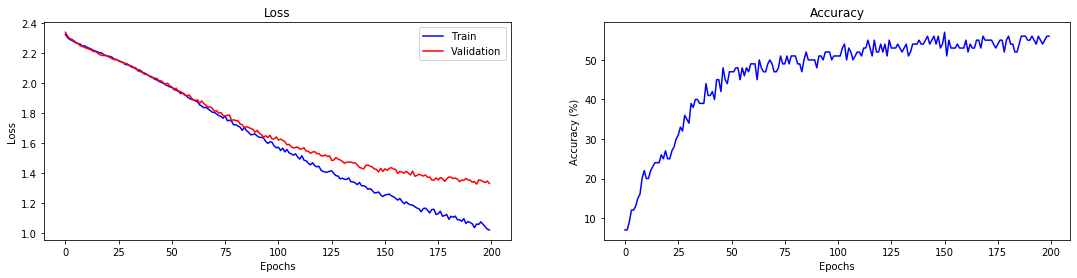


------ NEW EXPERIMENT ------
Dropout = 0.25	Hidden Size = [128, 64, 32, 16]	Learning Rate = 5e-05

Validation set: Average loss: 2.2816, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.2737, Accuracy: 17/100 (17%)


Validation set: Average loss: 2.2724, Accuracy: 16/100 (16%)


Validation set: Average loss: 2.2665, Accuracy: 18/100 (18%)


Validation set: Average loss: 2.259, Accuracy: 21/100 (21%)


Validation set: Average loss: 2.2542, Accuracy: 22/100 (22%)


Validation set: Average loss: 2.2483, Accuracy: 26/100 (26%)


Validation set: Average loss: 2.2412, Accuracy: 27/100 (27%)


Validation set: Average loss: 2.2415, Accuracy: 26/100 (26%)


Validation set: Average loss: 2.2239, Accuracy: 30/100 (30%)


Validation set: Average loss: 2.2281, Accuracy: 28/100 (28%)


Validation set: Average loss: 2.2226, Accuracy: 27/100 (27%)


Validation set: Average loss: 2.2251, Accuracy: 28/100 (28%)


Validation set: Average loss: 2.2143, Accuracy: 31/100 (31%)


Validation set: Ave


Validation set: Average loss: 1.5974, Accuracy: 48/100 (48%)


Validation set: Average loss: 1.6265, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.6173, Accuracy: 44/100 (44%)


Validation set: Average loss: 1.6294, Accuracy: 41/100 (41%)


Validation set: Average loss: 1.6151, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.6226, Accuracy: 43/100 (43%)


Validation set: Average loss: 1.5996, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.5881, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.5913, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.6126, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.5978, Accuracy: 45/100 (45%)


Validation set: Average loss: 1.6107, Accuracy: 49/100 (49%)


Validation set: Average loss: 1.597, Accuracy: 46/100 (46%)


Validation set: Average loss: 1.5955, Accuracy: 47/100 (47%)


Validation set: Average loss: 1.6208, Accuracy: 48/100 (48%)


Validation set: Average loss: 1.5951, Accuracy: 44/100 

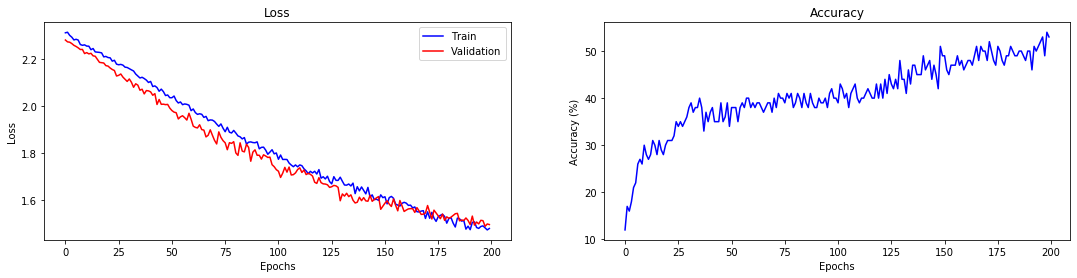


------ NEW EXPERIMENT ------
Dropout = 0.5	Hidden Size = [128, 64, 32, 16]	Learning Rate = 5e-05

Validation set: Average loss: 2.3095, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.3035, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.3043, Accuracy: 11/100 (11%)


Validation set: Average loss: 2.302, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.3017, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.2999, Accuracy: 13/100 (13%)


Validation set: Average loss: 2.2974, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.295, Accuracy: 13/100 (13%)


Validation set: Average loss: 2.2934, Accuracy: 14/100 (14%)


Validation set: Average loss: 2.2915, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2878, Accuracy: 14/100 (14%)


Validation set: Average loss: 2.2856, Accuracy: 15/100 (15%)


Validation set: Average loss: 2.2865, Accuracy: 12/100 (12%)


Validation set: Average loss: 2.2847, Accuracy: 13/100 (13%)


Validation set: Avera


Validation set: Average loss: 1.9295, Accuracy: 38/100 (38%)


Validation set: Average loss: 1.9207, Accuracy: 38/100 (38%)


Validation set: Average loss: 1.9565, Accuracy: 39/100 (39%)


Validation set: Average loss: 1.917, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.9216, Accuracy: 35/100 (35%)


Validation set: Average loss: 1.8961, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.9136, Accuracy: 40/100 (40%)


Validation set: Average loss: 1.9035, Accuracy: 39/100 (39%)


Validation set: Average loss: 1.9076, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.8858, Accuracy: 37/100 (37%)


Validation set: Average loss: 1.9089, Accuracy: 38/100 (38%)


Validation set: Average loss: 1.9032, Accuracy: 36/100 (36%)


Validation set: Average loss: 1.8954, Accuracy: 39/100 (39%)


Validation set: Average loss: 1.8978, Accuracy: 36/100 (36%)


Validation set: Average loss: 1.904, Accuracy: 38/100 (38%)


Validation set: Average loss: 1.8683, Accuracy: 37/100 (

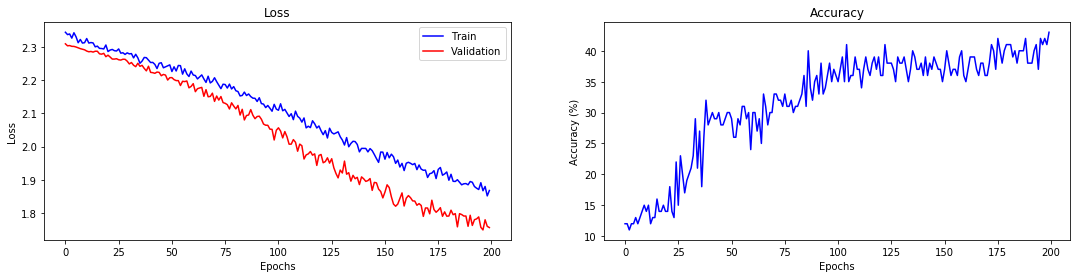

In [11]:
train_data_batches = data_batcher(train_data, train_batch_size)
val_data_batches = data_batcher(val_data, valid_batch_size)

for hidden_size in hidden_size_list:
    for learning_rate in learning_rate_list:
        for dropout in dropout_list:
            print(f'\n------ NEW EXPERIMENT ------\nDropout = {dropout}\tHidden Size = {hidden_size}\tLearning Rate = {learning_rate}')
            model = DNNClassifier(input_size, hidden_size, num_classes, dropout).to(device)

            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            train_losses = []
            valid_losses = []
            accuracies = []

            for epoch in range(num_epochs):
    
                train_loss = train(200, model, device, train_data_batches, optimizer, epoch)
                train_losses.append(train_loss)

                accuracy, valid_loss = validate(model, device, val_data_batches)
                valid_losses.append(valid_loss)
                accuracies.append(accuracy)
            
            plt_curves(train_losses, valid_losses, accuracies)